## Import Semua Packages/Library yang Digunakan

In [ ]:
import os, shutil
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import files
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [ ]:
import kagglehub
loki4514_rice_leaf_diseases_detection_path = kagglehub.dataset_download('loki4514/rice-leaf-diseases-detection')

print('Data source import complete.')

100%|██████████| 8.03G/8.03G [01:35<00:00, 90.0MB/s]

Extracting files...


Data source import complete.


In [ ]:
original_path = loki4514_rice_leaf_diseases_detection_path
destination_path = '/content/'

shutil.move(original_path, destination_path)

'/content/8'

In [ ]:
def to_snake_case(name):
    name = name.strip().lower()
    name = re.sub(r'[\s\-]+', '_', name)
    name = re.sub(r'[^a-z0-9_]', '', name)
    name = re.sub(r'__+', '_', name)
    return name

def standardize_folders(base_dir):
    original_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
    mapping = {}
    for folder in original_folders:
        standardized = to_snake_case(folder)
        mapping[folder] = standardized

    for original, std in mapping.items():
        original_path = os.path.join(base_dir, original)
        std_path = os.path.join(base_dir, std)

        if original == std:
            continue

        if not os.path.exists(std_path):
            os.makedirs(std_path)

        for filename in os.listdir(original_path):
            src_file =  os.path.join(original_path, filename)
            dst_file =  os.path.join(std_path, filename)
            shutil.move(src_file, dst_file)

        if len(os.listdir(original_path)) == 0:
            os.rmdir(original_path)

def prepare_dataframe(base_dir):
    data = []
    for label in os.listdir(base_dir):
        label_path = os.path.join(base_dir, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_full_path = os.path.join(label_path, file)
                    data.append((img_full_path, label))
    df = pd.DataFrame(data, columns=['img_path', 'label'])
    return df

def copy_files_to_dir(df, dest_dir):
    for _, row in df.iterrows():
        label_dir = os.path.join(dest_dir, row['label'])
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        src = row['img_path']
        dst = os.path.join(label_dir, os.path.basename(src))
        # Check if the source file actually exists before copying
        if os.path.exists(src):
             if not os.path.exists(dst):
                shutil.copy2(src, dst)
        else:
            # Optional: print a warning or log if a file is not found
            print(f"Warning: Source file not found - {src}")

#### Menentukan Direktori untuk Dataset

In [ ]:
train_dir = '/content/8/Rice_Leaf_Diease/Rice_Leaf_Diease/train'
test_dir = '/content/8/Rice_Leaf_Diease/Rice_Leaf_Diease/test'

def count_total_files(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        total_files += len(image_files)
    return total_files

total_train_files = count_total_files(train_dir)
total_test_files = count_total_files(test_dir)

print(f"Total file gambar di data train: {total_train_files} file")
print(f"Total file gambar di data test: {total_test_files} file")

Total file gambar di data train: 15023 file
Total file gambar di data test: 3422 file


#### Membuat Kamus untuk Menyimpan Gambar di Setiap Kelas

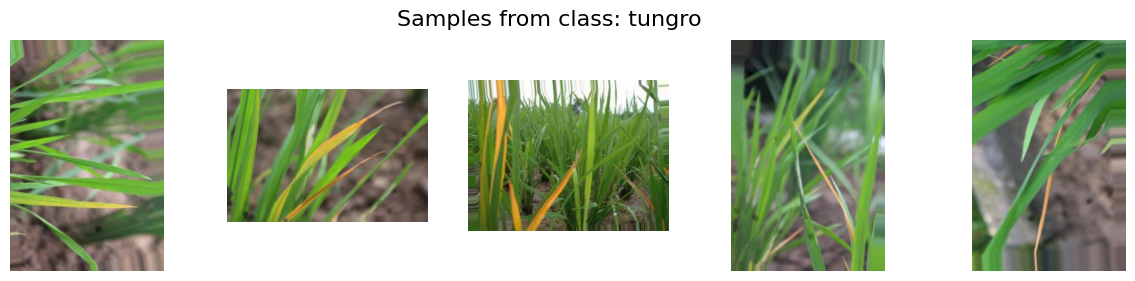

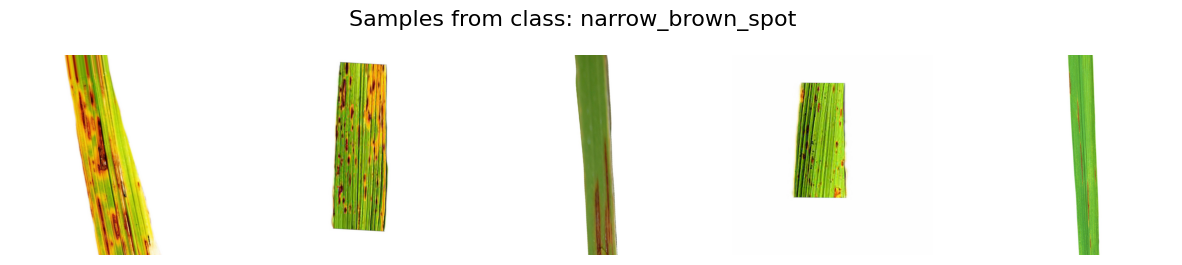

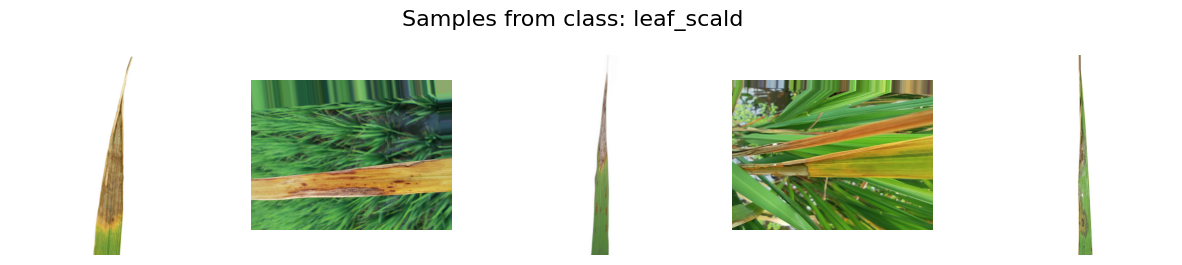

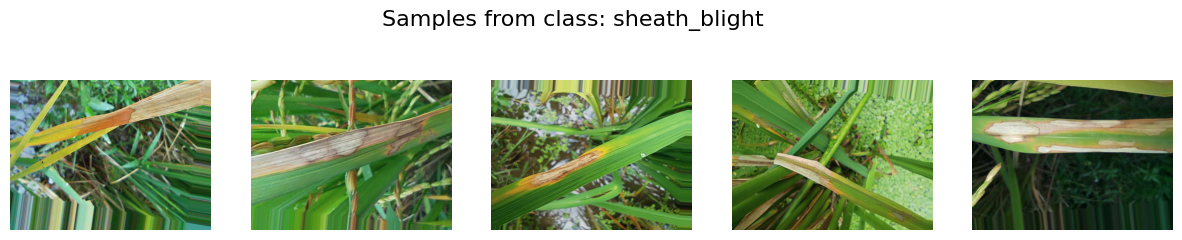

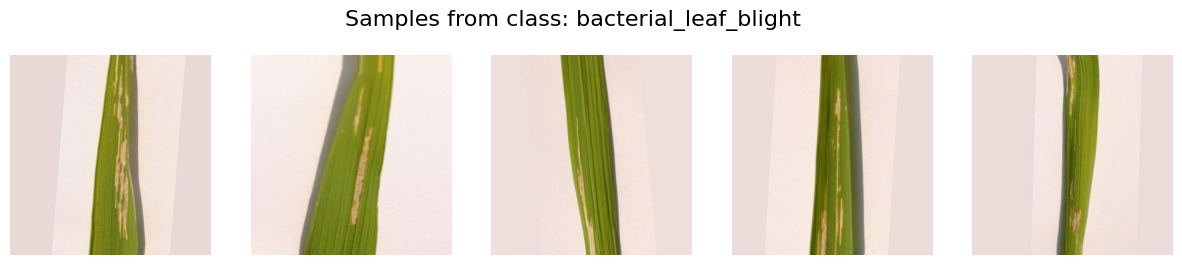

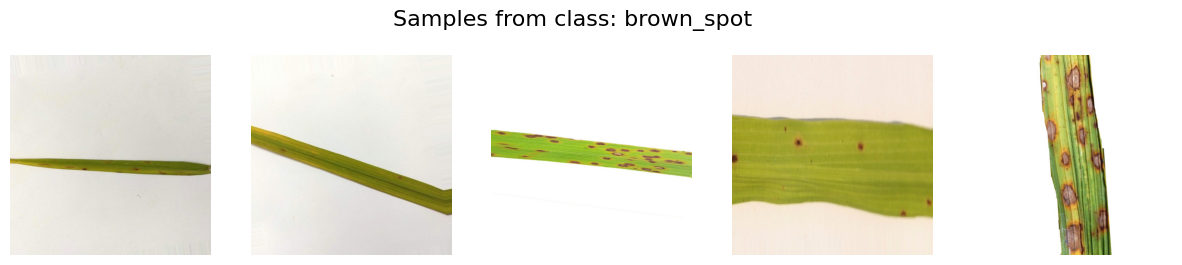

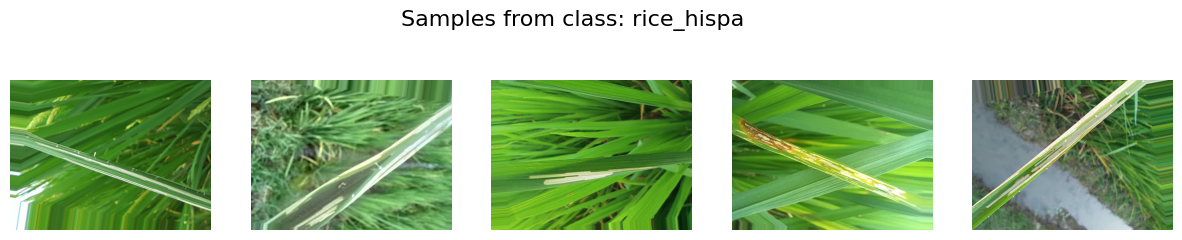

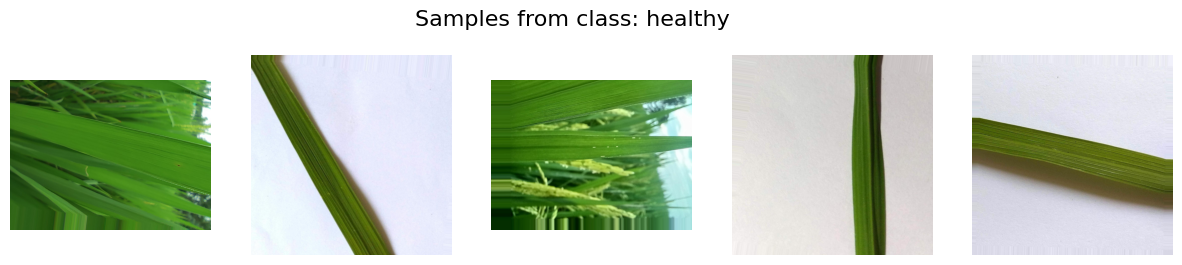

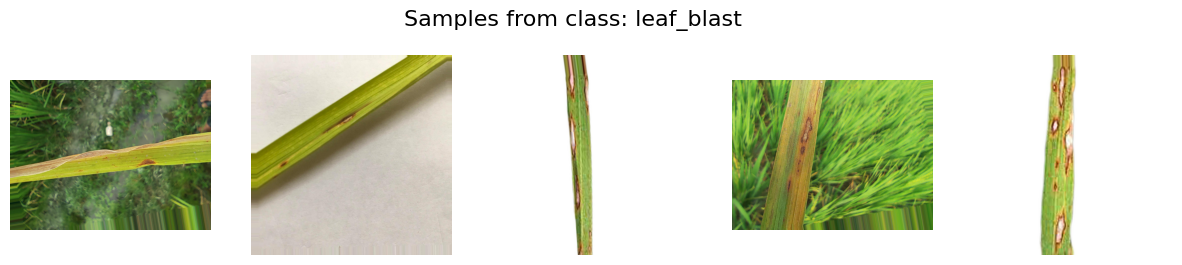

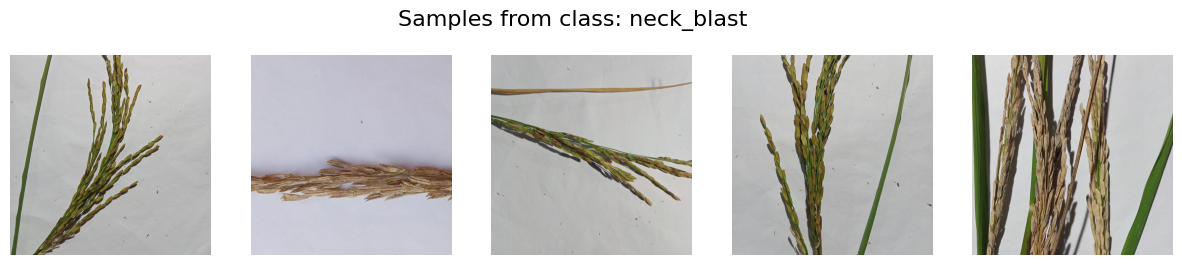

In [ ]:
def show_sample_images_per_class(base_dir, samples_per_class=5):
    class_names = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    for class_name in class_names:
        class_path = os.path.join(base_dir, class_name)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        sample_files = random.sample(image_files, min(samples_per_class, len(image_files)))

        plt.figure(figsize=(15, 3))
        plt.suptitle(f'Samples from class: {class_name}', fontsize=16)
        for i, img_file in enumerate(sample_files):
            img_path = os.path.join(class_path, img_file)
            img = load_img(img_path)
            plt.subplot(1, samples_per_class, i + 1)
            plt.imshow(img)
            plt.axis('off')
        plt.show()

show_sample_images_per_class(train_dir, samples_per_class=5)

In [ ]:
standardize_folders('/content/8/Rice_Leaf_AUG/Rice_Leaf_AUG')
standardize_folders('/content/8/Rice_Leaf_Diease/Rice_Leaf_Diease/test')
standardize_folders('/content/8/Rice_Leaf_Diease/Rice_Leaf_Diease/train')

In [ ]:
aug_path = '/content/8/Rice_Leaf_AUG/Rice_Leaf_AUG/'
aug_df = prepare_dataframe(aug_path)

# Now apply the label renaming to the dataframe
# This is already correct, but including it here for context after fixing paths
aug_df['label'] = aug_df['label'].replace({
    'narrow_brown_leaf_spot': 'narrow_brown_spot',
    'healthy_rice_leaf': 'healthy'
})

# Check the first few paths in aug_df to ensure they are correct after renaming
print("Sample paths in aug_df after standardizing and renaming:")
print(aug_df['img_path'].head())

Sample paths in aug_df after standardizing and renaming:
0    /content/8/Rice_Leaf_AUG/Rice_Leaf_AUG/leaf_sc...
1    /content/8/Rice_Leaf_AUG/Rice_Leaf_AUG/leaf_sc...
2    /content/8/Rice_Leaf_AUG/Rice_Leaf_AUG/leaf_sc...
3    /content/8/Rice_Leaf_AUG/Rice_Leaf_AUG/leaf_sc...
4    /content/8/Rice_Leaf_AUG/Rice_Leaf_AUG/leaf_sc...
Name: img_path, dtype: object


In [ ]:
train_df = prepare_dataframe(train_dir) # train_dir from /content/Rice_Leaf_Diease/Rice_Leaf_Diease/train
test_df = prepare_dataframe(test_dir)   # test_dir from /content/Rice_Leaf_Diease/Rice_Leaf_Diease/test


aug_train, aug_test = train_test_split(aug_df, test_size=0.15, stratify=aug_df['label'], random_state=42)

combined_train = pd.concat([train_df, aug_train]).reset_index(drop=True)

combined_test = pd.concat([test_df, aug_test]).reset_index(drop=True)

print(f"Ukuran data gabungan train: {combined_train.shape}")
print(f"Ukuran data gabungan test: {combined_test.shape}")

Ukuran data gabungan train: (25044, 2)
Ukuran data gabungan test: (5191, 2)


In [ ]:
train_df, val_df = train_test_split(
    combined_train,
    test_size=0.2,
    stratify=combined_train['label'],
    random_state=42
)

print(pd.crosstab(train_df['label'], columns='N').sort_values('N'))

print(f"Ukuran train setelah split val: {train_df.shape}")
print(f"Ukuran val: {val_df.shape}")
print(f"Ukuran test: {combined_test.shape}")

col_0                     N
label                      
tungro                 1392
neck_blast             1480
narrow_brown_spot      1782
bacterial_leaf_blight  1922
healthy                1930
rice_hispa             2052
brown_spot             2235
leaf_scald             2242
sheath_blight          2370
leaf_blast             2630
Ukuran train setelah split val: (20035, 2)
Ukuran val: (5009, 2)
Ukuran test: (5191, 2)


#### Plot Distribusi Setiap Kelas

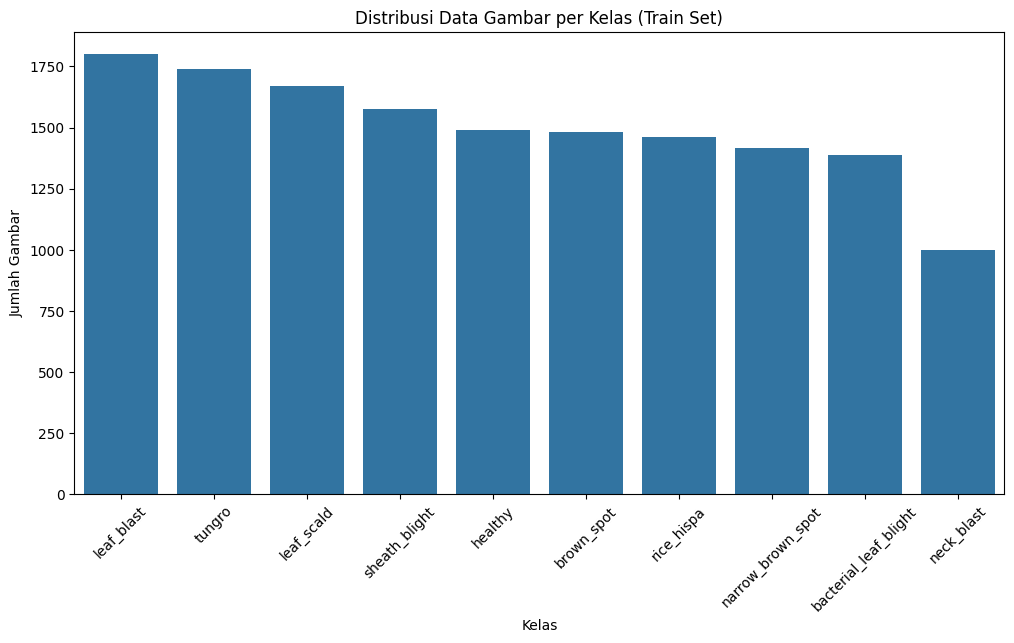

In [ ]:
def plot_class_distribution(directory, title='Distribusi Data per Kelas'):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            class_counts[class_name] = len(image_files)

    sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    classes, counts = zip(*sorted_classes)

    plt.figure(figsize=(12,6))
    sns.barplot(x=list(classes), y=list(counts))
    plt.title(title)
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_dir, 'Distribusi Data Gambar per Kelas (Train Set)')

### Data Preprocessing

In [ ]:

base_dir_final = '/content/dataset_final'  # Folder utama baru
train_dir_final = os.path.join(base_dir_final, 'train')
val_dir_final = os.path.join(base_dir_final, 'val')
test_dir_final = os.path.join(base_dir_final, 'test')

for d in [train_dir_final, val_dir_final, test_dir_final]:
    if not os.path.exists(d):
        os.makedirs(d)

In [ ]:
copy_files_to_dir(train_df, train_dir_final) # Use train_df which is the split from combined_train
copy_files_to_dir(val_df, val_dir_final)   # Use val_df which is the split from combined_train
copy_files_to_dir(combined_test, test_dir_final)

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Direkori final tempat data yang sudah digabung dan dipisah
train_dir_final = '/content/dataset_final/train'
val_dir_final = '/content/dataset_final/val'
test_dir_final = '/content/dataset_final/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    # width_shift_range=0.1, # Opsi tambahan untuk augmentasi jika diperlukan
    # height_shift_range=0.1, # Opsi tambahan untuk augmentasi jika diperlukan
    # shear_range=0.1, # Opsi tambahan untuk augmentasi jika diperlukan
    # zoom_range=0.1, # Opsi tambahan untuk augmentasi jika diperlukan
    fill_mode='nearest',
    horizontal_flip=True,
)

# Menggunakan flow_from_directory karena data sudah disalin ke direktori final
train_generator = train_datagen.flow_from_directory(
    directory=train_dir_final, # Mengarah ke direktori train final
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse', # Tetap sparse karena label y_true adalah integer
    shuffle=True,
    seed=1337
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan flow_from_directory untuk data validasi
val_generator = val_datagen.flow_from_directory(
    directory=val_dir_final, # Mengarah ke direktori val final
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False, # Tidak perlu di-shuffle untuk validasi
    seed=1337
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan flow_from_directory untuk data test
test_generator = test_datagen.flow_from_directory(
    directory=test_dir_final, # Mengarah ke direktori test final
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False, # Tidak perlu di-shuffle untuk test
    seed=1337
)

print("\nClass indices from train_generator:")
print(train_generator.class_indices)

Found 20035 images belonging to 10 classes.
Found 5009 images belonging to 10 classes.
Found 5037 images belonging to 10 classes.

Class indices from train_generator:
{'bacterial_leaf_blight': 0, 'brown_spot': 1, 'healthy': 2, 'leaf_blast': 3, 'leaf_scald': 4, 'narrow_brown_spot': 5, 'neck_blast': 6, 'rice_hispa': 7, 'sheath_blight': 8, 'tungro': 9}


## Modelling

#### Menggunakan Transfer Learning dari Mobile Net, dengan hanya mengambil feature extractornya saja dan tetap belajar dari model yang saya buat

In [ ]:
mobnet = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                              include_top=False,
                              weights='imagenet')
for layer in mobnet.layers:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = tf.keras.models.Sequential([
    mobnet,
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

history = model.fit(
    train_generator,
    epochs=28,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_reduction]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/28
627/627 ━━━━━━━━━━━━━━━━━━━━ 539s 840ms/step - accuracy: 0.3410 - loss: 1.8768 - val_accuracy: 0.6295 - val_loss: 1.0894 - learning_rate: 0.0010
Epoch 2/28
627/627 ━━━━━━━━━━━━━━━━━━━━ 509s 812ms/step - accuracy: 0.5647 - loss: 1.2575 - val_accuracy: 0.6572 - val_loss: 0.9814 - learning_rate: 0.0010
Epoch 3/28
627/627 ━━━━━━━━━━━━━━━━━━━━ 506s 808ms/step - accuracy: 0.6198 - loss: 1.1169 - val_accuracy: 0.7097 - val_loss: 0.9059 - learning_rate: 0.0010
Epoch 4/28
627/627 ━━━━━━━━━━━━━━━━━━━━ 499s 796ms/step - accuracy: 0.6396 - loss: 1.0590 - val_accuracy: 0.7177 - val_loss: 0.9120 - learning_rate: 0.0010
Epoch 5/28
627/627 ━━━━━━━━━━━━━━━━━━━━ 500s 797ms/step - accuracy: 0.6599 - loss: 0.9974 - val_accuracy: 0.6902 - val_loss: 0.9108 - learning_rate: 0.0010
Epoch 6/28
627/627 ━━━━━━━━━━━━━━━━━━━━ 498s 794ms/step - accuracy: 0.6727 - loss: 0.9618 - val_accuracy: 0.7267 - val_loss: 0.8536 - learning_rate: 0.0010
Epoch 7/28
627/627 ━━━━━━━━━━━━━━━━━━━━ 502s 801ms/step - accura

## Evaluasi dan Visualisasi

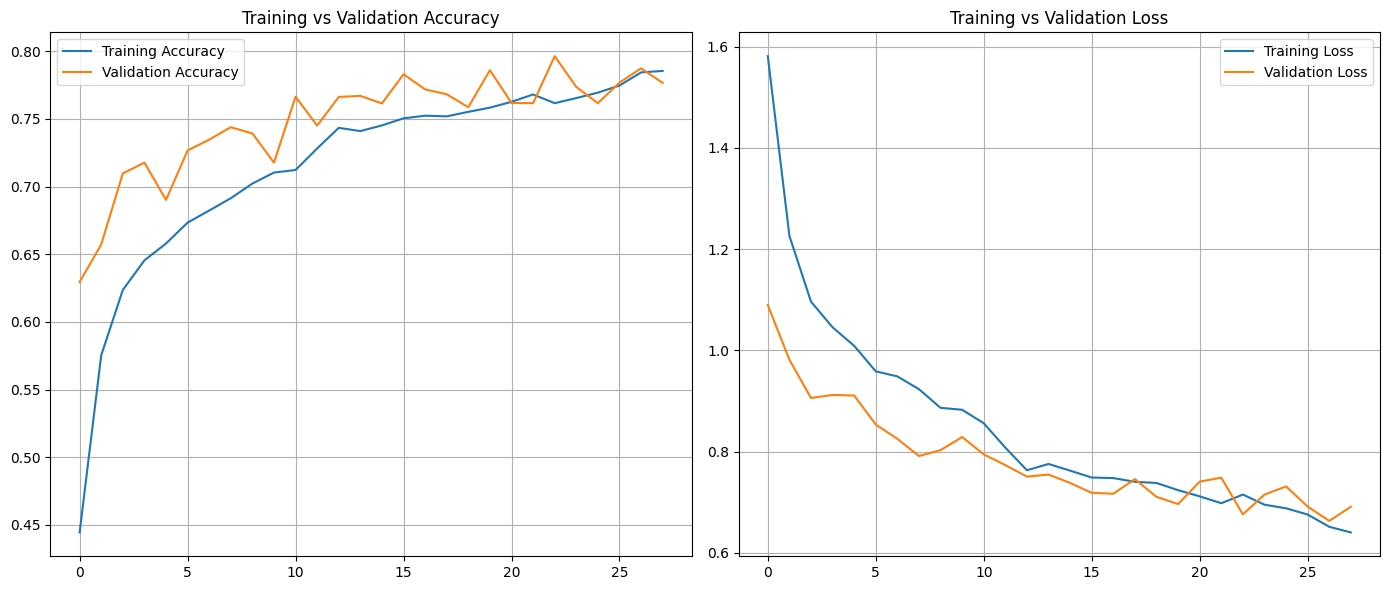

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

158/158 ━━━━━━━━━━━━━━━━━━━━ 84s 534ms/step - accuracy: 0.7467 - loss: 0.7311

Test Accuracy: 0.8197
Test Loss: 0.5904


158/158 ━━━━━━━━━━━━━━━━━━━━ 84s 509ms/step
📄 Classification Report:

                       precision    recall  f1-score   support

bacterial_leaf_blight       0.76      0.83      0.79       556
           brown_spot       0.93      0.52      0.66       612
              healthy       0.96      0.85      0.90       536
           leaf_blast       0.52      0.91      0.66       618
           leaf_scald       0.96      0.73      0.83       583
    narrow_brown_spot       0.88      0.72      0.79       519
           neck_blast       1.00      1.00      1.00       429
           rice_hispa       0.92      0.93      0.93       385
        sheath_blight       0.84      0.90      0.87       489
               tungro       0.99      0.97      0.98       310

             accuracy                           0.82      5037
            macro avg       0.88      0.84      0.84      5037
         weighted avg       0.86      0.82      0.82      5037



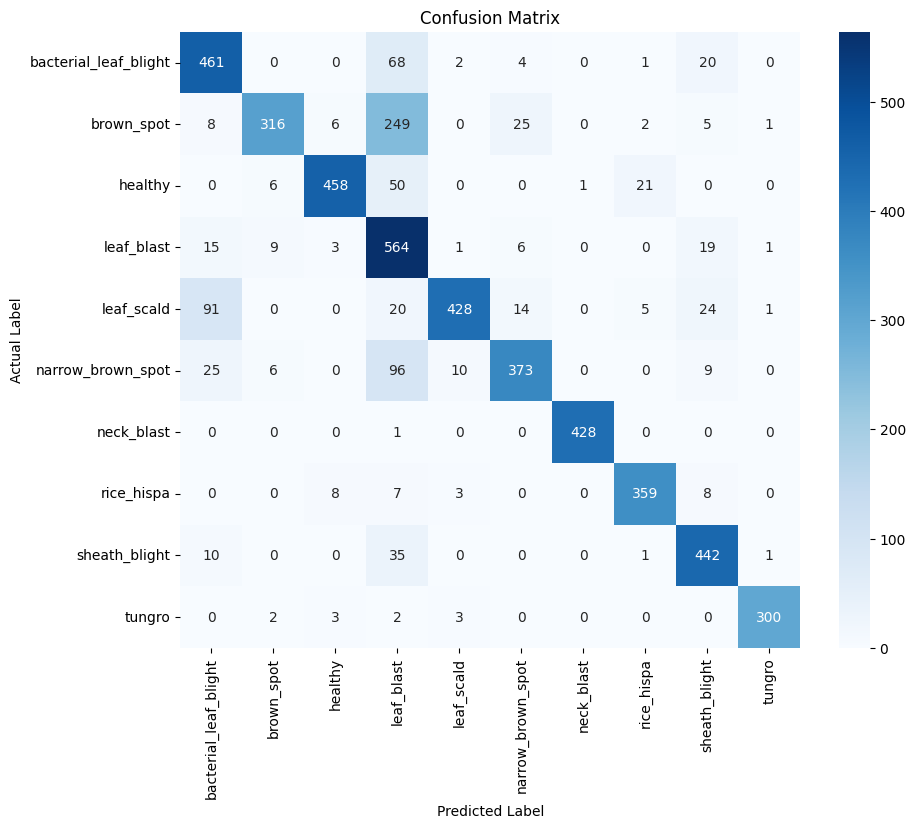

In [ ]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("📄 Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


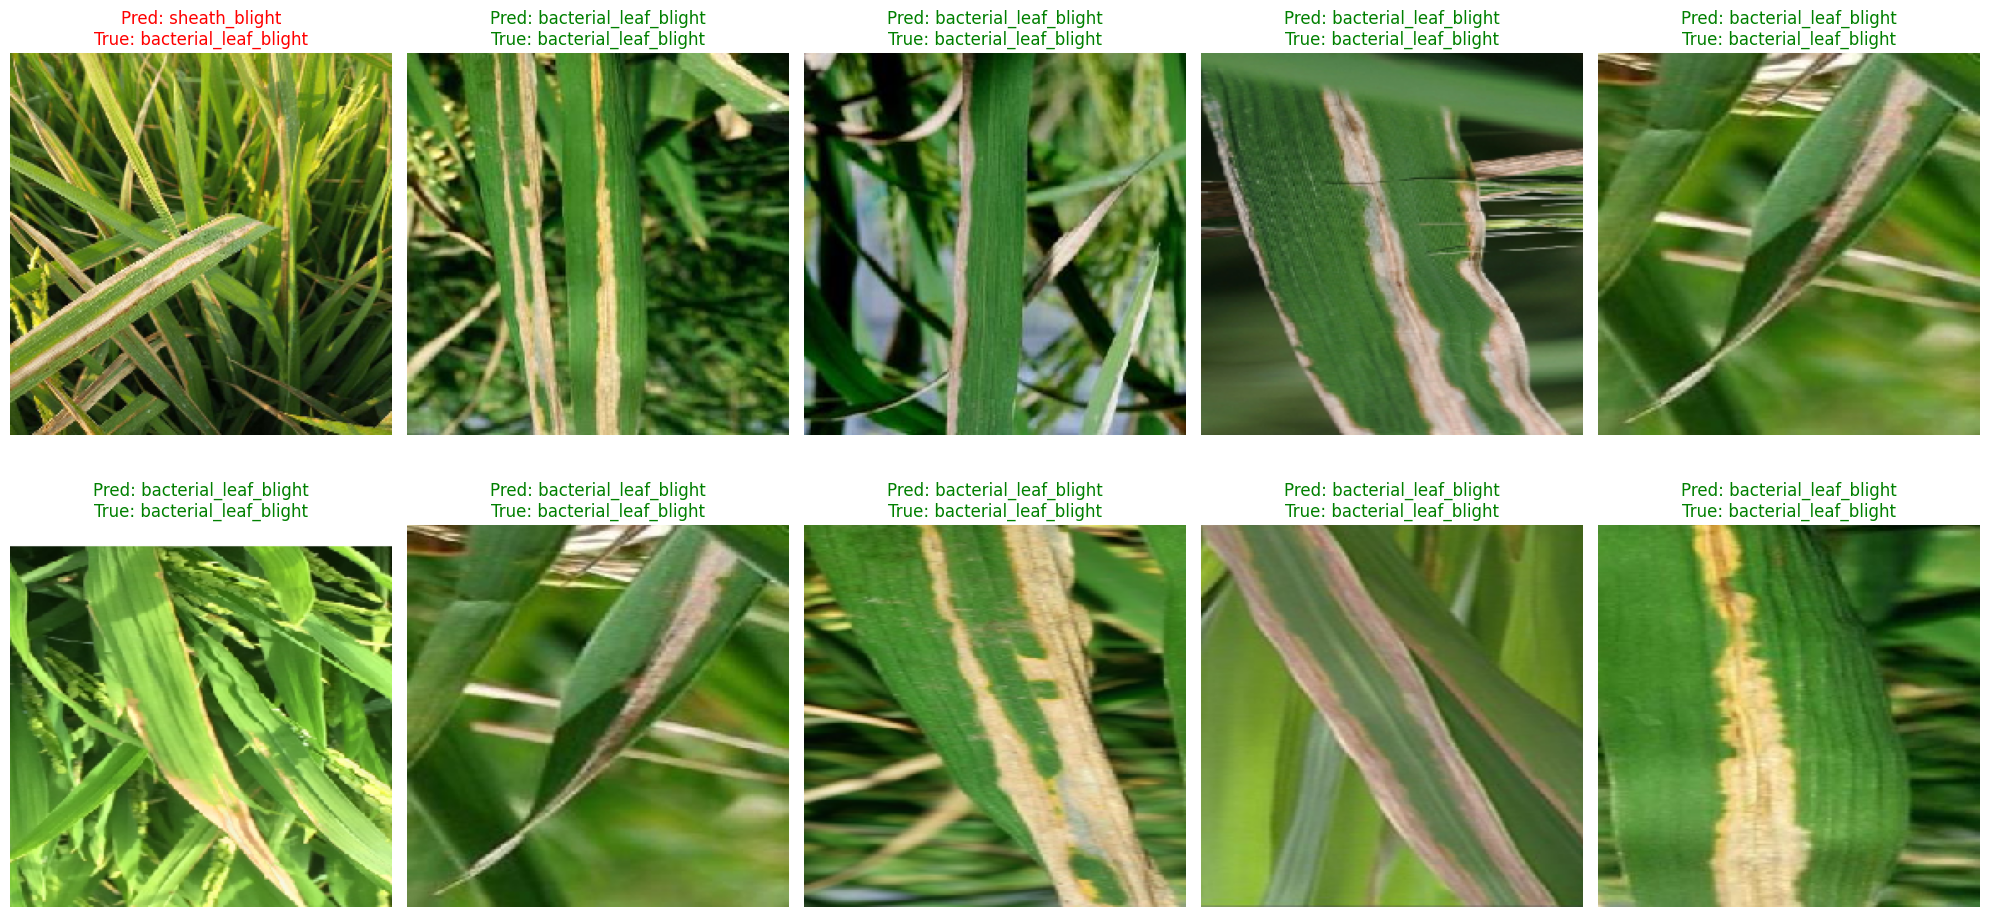

In [ ]:
test_generator.reset()

x_test, y_true = next(iter(test_generator))

y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

label_map = {v: k for k, v in test_generator.class_indices.items()}

plt.figure(figsize=(20, 10))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i])
    true_label = label_map[int(y_true[i])]
    pred_label = label_map[y_pred_labels[i]]
    color = "green" if y_pred_labels[i] == int(y_true[i]) else "red"
    ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis("off")
plt.tight_layout()
plt.show()

## Konversi Model

In [ ]:
import pickle

filename = 'finalized_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
model.export("saved_model")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136162166053712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136162166051408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136162160509200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136162166060624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136162166062928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136162166050832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136162160509392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136162160509008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136162160510736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136162160510352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13616216051112

In [ ]:
!zip -r /content/saved_model.zip /content/saved_model
files.download('/content/saved_model.zip')

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/fingerprint.pb (stored 0%)
  adding: content/saved_model/assets/ (stored 0%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.index (deflated 78%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/saved_model/saved_model.pb (deflated 91%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
os.makedirs("tflite", exist_ok=True)

converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()

with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke TFLite")

Model berhasil dikonversi ke TFLite


In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_node_names='StatefulPartitionedCall' \
    --saved_model_tags=serve \
    model_animal10 \
    tfjs_model

2025-04-24 03:34:45.716887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745465685.785863   45711 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745465685.800953   45711 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-24 03:34:52.269743: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745465692.269913   45711 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## Inference (Optional)

In [ ]:
def predict_image(img_path, model, class_indices):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    label_map = {v: k for k, v in class_indices.items()}
    predicted_class_label = label_map[predicted_class_index]
    confidence = prediction[0][predicted_class_index]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {predicted_class_label}\nConfidence: {confidence:.2f}")
    plt.show()

    return predicted_class_label, confidence

In [ ]:
uploaded = files.upload()

Saving padi-bercak.jpg to padi-bercak.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


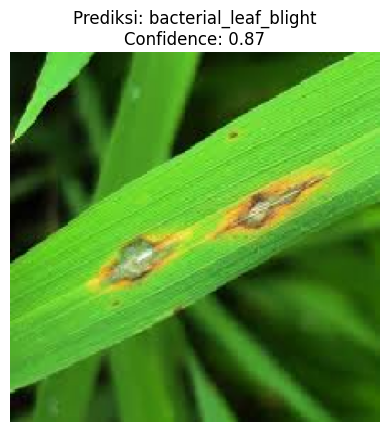

('bacterial_leaf_blight', np.float32(0.8700406))

In [ ]:
predict_image("padi-bercak.jpg", model, test_generator.class_indices)